In [3]:
from matplotlib.pyplot import imread
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import datetime
import zipfile
import bisect
import os
import re

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

## **1. Download the dataset and understand the format (10 Points)**

In [5]:
#unzipped = zipfile.ZipFile("orl_faces.zip", 'r')
#unzipped.extractall()

## **2. Generate the Data Matrix and the Label vector (10 Points)**

In [6]:
data = []
labels = []
maindir = "orl_faces"

for subdir in os.listdir(maindir):
    if (subdir == "README"):
        continue
    path = os.path.join(maindir, subdir)
    for pic in os.listdir(path):
        labels.append(int(re.sub("s", "", subdir)))
        img_path = os.path.join(path, pic)
        image = imread(img_path, format = "pgm")
        x,y = image.shape
        image = image.reshape(x*y)
        data.append(image)
    
data = np.array(data)

## **3. Split the Dataset into Training and Test sets (10 Points)**

In [7]:
mask = ([False] * 5 + [True] * 5) * 40

X_train = np.array(list(compress(data, mask)))
y_train = np.array(list(compress(labels, mask)))

X_test = np.array(list(compress(data, np.invert(mask))))
y_test = np.array(list(compress(labels, np.invert(mask))))

## **4. Classification using PCA.(30 points)**

In [8]:
class PCA():
    def __init__(self):
        self.explained_variances = None
        self.cumulative_sum = None
        self.sorted_eigenvectors = None
   
    def solve(self, X_train):
        n = X_train.shape[0]
        means = np.mean(X_train, axis = 0)                                #1
        centered_data = X_train - means                                   #2
        covariance = np.dot(centered_data.T, centered_data)/n             #3
        
        print (str(datetime.datetime.now()), " -- covariance done")
        eigenvalues, eigenvectors = np.linalg.eigh(covariance)       #4, 5
        print (str(datetime.datetime.now()), " -- eigenvectors done")
        
        self.explained_variances, self.sorted_eigenvectors = np.flip(eigenvalues, axis = 0), np.flip(eigenvectors, axis = 1)
    
        self.cumulative_sum = np.cumsum(self.explained_variances) / np.sum(self.explained_variances)  #6
    
    
    def get_projection_matrix(self, alpha):
        stop_index = bisect.bisect(self.cumulative_sum, alpha)
        return self.sorted_eigenvectors[:, 0:stop_index]
      

In [9]:
pca = PCA()
pca.solve(X_train)

2019-03-11 14:56:56.477047  -- covariance done
2019-03-11 14:58:43.359301  -- eigenvectors done


In [10]:
print(pca.cumulative_sum[-1])
alpha_values = [0.8, 0.85, 0.9, 0.95]
for alpha in alpha_values:
    projection_matrix = pca.get_projection_matrix(alpha)
    print(projection_matrix.shape)

1.0000000000000004
(10304, 36)
(10304, 52)
(10304, 76)
(10304, 116)


## **5. Classification using LDA(30 points)**

In [11]:
class LDA():
    def __init__(self):
        self.scatter_b = None
        self.scatter_w = None
        self.dominant_eigenvectors = None
        
    def solve(self, x_train, y_train, num_vectors):
        n, m = x_train.shape[0], x_train.shape[1]
        unique_classes = np.unique(y_train)
        
        total_mean = np.mean(x_train, axis = 0)
        means = np.zeros((unique_classes.size, m))
        nks = np.zeros(unique_classes.size)
        self.scatter_w = np.zeros((m, m))

        for label, c in zip(unique_classes, range(unique_classes.size)):
            class_examples = x_train[y_train == label]
            nks[c] = class_examples.shape[0]
            means[c] = np.mean(class_examples, axis = 0)
            centered_data = np.matrix(class_examples - means[c])
            self.scatter_w += np.matmul(centered_data.T, centered_data)
            
        print (str(datetime.datetime.now()), " -- loops done")
        normalized_means = np.matrix(means - total_mean).T
        self.scatter_b = np.matmul(np.multiply(nks.T, normalized_means), normalized_means.T)
               
        print (str(datetime.datetime.now()), " -- scatter_b done")
        s_inv = np.linalg.pinv(self.scatter_w)
        print (str(datetime.datetime.now()), " -- inverse done")
        eigenvalues, eigenvectors = np.linalg.eig(np.matmul(s_inv, self.scatter_b))
        print (str(datetime.datetime.now()), " -- eigenvectors done")
        
        indices = np.flip(np.argsort(eigenvalues), axis = 0)[0:num_vectors]
        self.dominant_eigenvectors = eigenvectors[:, indices]            

In [25]:
num_vectors = 39
lda = LDA()
lda.solve(X_train, y_train, num_vectors)

2019-03-11 15:01:24.104791  -- loops done
2019-03-11 15:01:24.643352  -- scatter_b done
2019-03-11 15:08:19.749258  -- inverse done
2019-03-11 15:14:57.808958  -- eigenvectors done


## 6. Classifier Tuning (20 points)


### For PCA

In [12]:
alpha_values = [0.8, 0.85, 0.9, 0.95]
k_values = [1, 3, 5, 7]
train_scores = np.zeros((len(alpha_values), len(k_values)))
test_scores = np.zeros((len(alpha_values), len(k_values)))
for i in range(len(alpha_values)):
    projection_matrix = pca.get_projection_matrix(alpha_values[i])
    
    #projection_matrix = pca.sorted_eigenvectors
    print(projection_matrix.shape)
    projected_train_data = np.matmul(X_train, projection_matrix)
    projected_test_data = np.matmul(X_test, projection_matrix)
    
    for k in range(len(k_values)):
        knn = KNeighborsClassifier(n_neighbors = k_values[k])
        knn.fit(projected_train_data, y_train)
        
        train_predictions = knn.predict(projected_train_data)
        test_predictions = knn.predict(projected_test_data)
        
        train_scores[i,k] = accuracy_score(y_train, train_predictions)
        test_scores[i,k] = accuracy_score(y_test, test_predictions)

(10304, 36)
(10304, 52)
(10304, 76)
(10304, 116)


In [13]:
print(train_scores)
print(test_scores)

[[1.    0.95  0.935 0.85 ]
 [1.    0.95  0.915 0.87 ]
 [1.    0.95  0.905 0.855]
 [1.    0.955 0.895 0.85 ]]
[[0.925 0.825 0.765 0.725]
 [0.925 0.825 0.78  0.72 ]
 [0.935 0.815 0.785 0.73 ]
 [0.935 0.83  0.8   0.735]]


Text(0,0.5,'Accuracy')

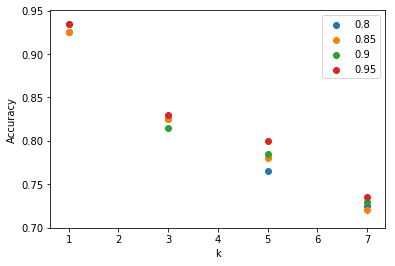

In [14]:
plt.scatter([1, 3, 5, 7], [0.925, 0.825, 0.765, 0.725])
plt.scatter([1, 3, 5, 7], [0.925, 0.825, 0.78,  0.72])
plt.scatter([1, 3, 5, 7], [0.935, 0.815, 0.785, 0.73])
plt.scatter([1, 3, 5, 7], [0.935, 0.83,  0.8, 0.735])
plt.legend(['0.8','0.85', '0.9', '0.95'])
plt.xlabel('k')
plt.ylabel('Accuracy')

Text(0,0.5,'Accuracy')

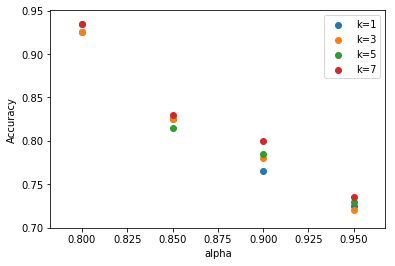

In [15]:
plt.scatter([0.8, 0.85, 0.9, 0.95], [0.925, 0.825, 0.765, 0.725])
plt.scatter([0.8, 0.85, 0.9, 0.95], [0.925, 0.825, 0.78,  0.72])
plt.scatter([0.8, 0.85, 0.9, 0.95], [0.935, 0.815, 0.785, 0.73])
plt.scatter([0.8, 0.85, 0.9, 0.95], [0.935, 0.83,  0.8, 0.735])
plt.legend(['k=1','k=3', 'k=5', 'k=7'])
plt.xlabel('alpha')
plt.ylabel('Accuracy')

### For LDA

In [26]:
projected_train_data = np.dot(X_train, lda.dominant_eigenvectors)
projected_train_data.shape

projected_test_data = np.dot(X_test, lda.dominant_eigenvectors)
projected_test_data.shape

(200, 39)

In [27]:
k_values = [1, 3, 5, 7, 9]
train_scores = []
test_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn = knn.fit(projected_train_data, y_train)
    
    train_predictions = knn.predict(projected_train_data)
    test_predictions = knn.predict(projected_test_data)
    
    train_scores.append(accuracy_score(y_train, train_predictions))
    test_scores.append(accuracy_score(y_test, test_predictions))

D:\Users\AbdElRahman\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\Users\AbdElRahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


[1.0, 0.86, 0.865, 0.865, 0.875]
[0.84, 0.8, 0.815, 0.79, 0.78]


Text(0,0.5,'Accuracy')

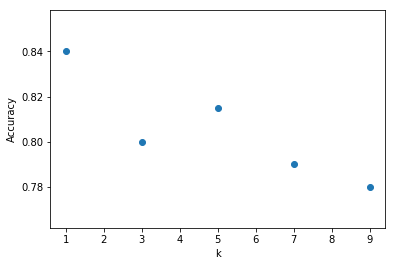

In [28]:
print(train_scores)
print(test_scores)
plt.scatter([1, 3, 5, 7, 9], test_scores)
plt.xlabel('k')
plt.ylabel('Accuracy')

## 7. BONUS (20 Points)

#### a. [5 points] Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. compare the results you have with the ones you got earlier with 50% split.

In [16]:
mask = ([True] * 7 + [False] * 3) * 40

X_train_bonus = np.array(list(compress(data, mask)))
y_train_bonus = np.array(list(compress(labels, mask)))

X_test_bonus = np.array(list(compress(data, np.invert(mask))))
y_test_bonus = np.array(list(compress(labels, np.invert(mask))))

In [17]:
pca_bonus = PCA()
pca_bonus.solve(X_train_bonus)

2019-03-11 14:58:46.508060  -- covariance done
2019-03-11 15:00:32.252324  -- eigenvectors done


In [18]:
alpha_bonus = 0.75
projection_matrix_bonus = pca_bonus.get_projection_matrix(alpha_bonus)
projected_train_data_bonus = np.matmul(X_train_bonus, projection_matrix_bonus)
projected_test_data_bonus = np.matmul(X_test_bonus, projection_matrix_bonus)

projected_train_data_bonus.shape

(280, 26)

In [19]:
k_bonus = 1
knn_bonus = KNeighborsClassifier(n_neighbors = k_bonus)
knn_bonus.fit(projected_train_data_bonus, y_train_bonus)

train_predictions_bonus = knn_bonus.predict(projected_train_data_bonus)
test_predictions_bonus = knn_bonus.predict(projected_test_data_bonus)

train_scores_bonus = accuracy_score(y_train_bonus, train_predictions_bonus)
test_scores_bonus = accuracy_score(y_test_bonus, test_predictions_bonus)

In [20]:
print(train_scores_bonus)
print(test_scores_bonus)

1.0
0.9583333333333334


#### b. [15 points] Download non-face images and make them of same size 92x112. and try to solve the classification problem faces vs. Non-faces.
#####             i. Show failure and success cases.
#####             ii. How many dominant eigenvectors will you use for the LDA solution?
#####             iii. Plot the accuracy vs the number of non-faces images while fixing the number of face images.
#####             iv. Criticize the accuracy measure for large numbers of non-faces images in the training data.

In [21]:
from PIL import Image 

In [22]:
path_bonus = "not_faces"
width, height = 112, 92
data_bonus = []

for pic in os.listdir(path_bonus):
    img_path = os.path.join(path_bonus, pic)
    img = Image.open(img_path)
    img = img.resize((width, height))
    img = img.convert('L')
    image = np.array(img.getdata())
    data_bonus.append(image)
    
data_bonus = np.array(data_bonus)    
print(data_bonus.shape)

(400, 10304)


In [23]:
label_dict = {1: "Face", 0: "Other"}
labels_bonus = [1] * 400 + [0] * 400
all_data = np.concatenate((data, data_bonus))
print(all_data.shape)

(800, 10304)


In [24]:
mask = ([True] * 300 + [False] * 100) * 2

X_train_bonus2 = np.array(list(compress(all_data, mask)))
y_train_bonus2 = np.array(list(compress(labels_bonus, mask)))

X_test_bonus2 = np.array(list(compress(all_data, np.invert(mask))))
y_test_bonus2 = np.array(list(compress(labels_bonus, np.invert(mask))))

In [37]:
num_vectors = 40
lda_bonus = LDA()
lda_bonus.solve(X_train_bonus2, y_train_bonus2, num_vectors)

2019-03-11 15:25:08.603981  -- loops done
2019-03-11 15:25:09.592342  -- scatter_b done
2019-03-11 15:32:14.058430  -- inverse done
2019-03-11 21:31:16.421937  -- eigenvectors done


In [38]:
print(lda_bonus.dominant_eigenvectors)

[[ 4.17279090e-02+0.j          1.26647687e-02-0.03023384j
   1.26647687e-02+0.03023384j ...  4.54172985e-02+0.00253888j
   4.54172985e-02-0.00253888j  1.40900473e-03+0.02322283j]
 [-7.07242813e-01+0.j         -3.04529607e-01+0.12931727j
  -3.04529607e-01-0.12931727j ... -1.30748315e-02-0.03792549j
  -1.30748315e-02+0.03792549j -1.36061633e-03+0.05105257j]
 [-2.69491778e-01+0.j          1.05657273e-01-0.11370221j
   1.05657273e-01+0.11370221j ... -2.00420493e-03-0.02889095j
  -2.00420493e-03+0.02889095j -3.58233046e-02+0.00899632j]
 ...
 [ 3.27160247e-03+0.j         -2.29683050e-03-0.00836082j
  -2.29683050e-03+0.00836082j ...  4.52909560e-03+0.00220151j
   4.52909560e-03-0.00220151j  6.93952754e-03+0.00219125j]
 [ 7.45908107e-04+0.j         -9.22375323e-04-0.00200706j
  -9.22375323e-04+0.00200706j ...  2.73015827e-04-0.00264044j
   2.73015827e-04+0.00264044j  1.11517080e-03+0.00177436j]
 [ 5.08208794e-03+0.j          5.42034048e-03-0.00073255j
   5.42034048e-03+0.00073255j ...  1.80659

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [40]:
projected_train_data = np.matmul(X_train_bonus2, lda_bonus.dominant_eigenvectors)
projected_test_data = np.matmul(X_test_bonus2, lda_bonus.dominant_eigenvectors)

svm = SVC().fit(projected_train_data, y_train_bonus2)
lr = LogisticRegression().fit(projected_train_data, y_train_bonus2)

svm_train_predictions = svm.predict(projected_train_data)
lr_train_predictions = lr.predict(projected_train_data)

svm_test_predictions = svm.predict(projected_test_data)
lr_test_predictions = lr.predict(projected_test_data)

print("Train Results: svm")
print(accuracy_score(y_train_bonus2, svm_train_predictions))
print(precision_score(y_train_bonus2, svm_train_predictions))
print(recall_score(y_train_bonus2, svm_train_predictions))

print("Test Results: svm")
print(accuracy_score(y_test_bonus2, svm_test_predictions))
print(precision_score(y_test_bonus2, svm_test_predictions))
print(recall_score(y_test_bonus2, svm_test_predictions))

print("Train Results: lr")
print(accuracy_score(y_train_bonus2, lr_train_predictions))
print(precision_score(y_train_bonus2, lr_train_predictions))
print(recall_score(y_train_bonus2, lr_train_predictions))

print("Test Results: lr")
print(accuracy_score(y_test_bonus2, lr_test_predictions))
print(precision_score(y_test_bonus2, lr_test_predictions))
print(recall_score(y_test_bonus2, lr_test_predictions))

D:\Users\AbdElRahman\Anaconda3\lib\site-packages\sklearn\utils\validation.py:433: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


Train Results: svm
1.0
1.0
1.0
Test Results: svm
0.5
0.0
0.0
Train Results: lr
1.0
1.0
1.0
Test Results: lr
0.51
0.5096153846153846
0.53


D:\Users\AbdElRahman\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Testing 

In [29]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 5C1D-07F6

 Directory of C:\Users\Abd El Rahman\Desktop\College\Term 8\Pattern recognition\Projects\Face Recognition

03/11/2019  03:08 PM    <DIR>          .
03/11/2019  03:08 PM    <DIR>          ..
03/03/2019  12:09 PM    <DIR>          .ipynb_checkpoints
04/18/1994  03:17 PM            10,318 1.pgm
03/01/2019  08:09 PM         4,075,767 att_faces.tar.Z
03/01/2019  07:58 PM            41,135 Colab.ipynb
03/11/2019  03:08 PM            46,285 Jupyter.ipynb
03/07/2019  09:48 PM    <DIR>          not_faces
03/07/2019  09:33 PM    <DIR>          notFaces
03/01/2019  03:53 PM    <DIR>          orl_faces
03/01/2019  08:35 PM         3,801,749 orl_faces.zip
03/07/2019  11:49 PM            93,771 Report.pdf
03/07/2019  09:37 PM             2,019 result.png
03/05/2019  12:28 AM             2,061 Untitled.ipynb
               8 File(s)      8,073,105 bytes
               6 Dir(s)  18,466,070,528 bytes free


In [30]:
width, height = 112, 92
img = Image.open("not_faces\\000000452515.jpg") # open colour image
img_resized = img.resize((width, height))
img_resized.show()
img_greyscale = img_resized.convert('L')
img_greyscale.show()

In [31]:
cd notFaces

C:\Users\Abd El Rahman\Desktop\College\Term 8\Pattern recognition\Projects\Face Recognition\notFaces


In [32]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 5C1D-07F6

 Directory of C:\Users\Abd El Rahman\Desktop\College\Term 8\Pattern recognition\Projects\Face Recognition\notFaces

03/07/2019  09:33 PM    <DIR>          .
03/07/2019  09:33 PM    <DIR>          ..
08/16/2014  03:02 AM           155,667 000000000632.jpg
08/16/2014  03:05 AM           321,136 000000001000.jpg
08/16/2014  03:01 AM           111,309 000000001425.jpg
08/16/2014  02:37 AM           174,022 000000001532.jpg
08/16/2014  02:47 AM            97,643 000000001675.jpg
08/16/2014  02:40 AM           202,589 000000002006.jpg
08/16/2014  03:09 AM           136,034 000000002153.jpg
08/16/2014  02:46 AM           165,837 000000004795.jpg
08/16/2014  02:56 AM           166,135 000000006012.jpg
08/16/2014  03:03 AM           291,912 000000007278.jpg
08/16/2014  03:08 AM           135,698 000000007511.jpg
08/16/2014  02:31 AM           163,988 000000007574.jpg
08/16/2014  03:04 AM           231,097 000000008629.jpg
08/16/2

In [33]:
cd ..

C:\Users\Abd El Rahman\Desktop\College\Term 8\Pattern recognition\Projects\Face Recognition


In [34]:
x = np.array([[1, 2, 3, 4, 5],
     [6, 7, 8, 9, 10]])
y = np.array([1, 1, 2, 1, 2])
x - y

array([[0, 1, 1, 3, 3],
       [5, 6, 6, 8, 8]])

In [35]:
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T
np.cov(X)

array([[ 3.90962162, -2.36707834,  0.9263888 , ..., -0.19369231,
         0.5105725 , -1.30616337],
       [-2.36707834,  1.43314632, -0.56088161, ...,  0.11727091,
        -0.30912585,  0.79081592],
       [ 0.9263888 , -0.56088161,  0.21950877, ..., -0.04589559,
         0.12098067, -0.30949673],
       ...,
       [-0.19369231,  0.11727091, -0.04589559, ...,  0.009596  ,
        -0.02529502,  0.06471056],
       [ 0.5105725 , -0.30912585,  0.12098067, ..., -0.02529502,
         0.06667762, -0.17057689],
       [-1.30616337,  0.79081592, -0.30949673, ...,  0.06471056,
        -0.17057689,  0.43637541]])

In [36]:
a = np.array([[1, 2, 3],
              [4, 5, 6]])
np.mean(a, axis = 0)

array([2.5, 3.5, 4.5])